Capstone 1: Predicting Psychological Distress

Step 1: Data Cleaning

Data from http://healthpolicy.ucla.edu/chis/Pages/default.aspx

In [31]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_ind
from scipy.stats import chi2
from scipy.stats import chi2_contingency

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.feature_selection import RFECV

In [32]:
#Read Data
data = pd.read_sas("data/adult.sas7bdat")
labels = pd.read_csv('data/adult_label.sas', sep="=", header = 0)
formats = pd.read_csv('data/adult_format.sas', sep="\s+", header=0)

In [33]:
#Delete Proxy interviews, replace -1
proxies = data.loc[data.PROXY == 1].index
data = data.drop(proxies)
data = data.replace(-1.0, np.nan)
data.reset_index(drop=True, inplace=True)
data.tail()

,AA5C,AB1,AB17,AB40,AB41,AB43,AB98,AB22,AB99,AB24,...,RAKEDW71,RAKEDW72,RAKEDW73,RAKEDW74,RAKEDW75,RAKEDW76,RAKEDW77,RAKEDW78,RAKEDW79,RAKEDW80
21145,NaN,4.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,...,5088.729442,4770.000660,5216.366559,4707.561299,4703.567018,5267.524416,4968.267433,4918.001716,5028.950780,4806.546705
21146,NaN,2.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,...,1190.869548,1169.937516,1181.456280,1179.692599,1184.624914,1177.753053,1139.878279,1253.028286,1163.102790,1207.593124
21147,NaN,2.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,2119.722107,2029.294617,2148.677633,2014.806671,2055.090999,2127.905676,2024.376610,2207.089088,1951.723791,2317.924681
21148,NaN,4.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,...,1322.954103,1474.503676,1417.676179,1384.670592,1375.455887,1427.110297,1418.392983,1328.936250,1377.774001,1414.208651
21149,NaN,4.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,...,7268.491527,6656.538267,7094.919583,6880.847710,6858.592959,6849.272946,6661.410439,7431.478774,7230.218936,6982.443598


Manually selected columns. Only using questions asked to all respondents, removed columns that included duplicate information from other questions, selected columns of interest

In [34]:
#Select Columns
select_cols_df = pd.read_csv("select_cols.csv")
select_cols = list(select_cols_df["select_cols"])
selected_data = data[select_cols]
selected_data.shape

(21150, 78)

In [35]:
#Convert column names to readable labels
col_dict = labels.to_dict()
col_dict = col_dict["LABEL"]
col_dict.pop(";")
str_col_dict = {}

for k, v in col_dict.items():
    k_new = k.strip()
    v_new = v.strip().strip("\"")
    str_col_dict[k_new] = v_new
    
cols = selected_data.columns
new_cols = [str_col_dict[val] for val in cols]
selected_data.columns = new_cols

In [36]:
#One-Hot-Encoding Categorical Columns
categorical_cols = list(select_cols_df.loc[select_cols_df.type == "cat",["select_cols"]]["select_cols"])
categorical_cols = [str_col_dict[val] for val in categorical_cols]
categorical_data = selected_data[categorical_cols]
enc = OneHotEncoder(categories='auto', sparse=False)
enc_cat_data = pd.DataFrame(enc.fit_transform(categorical_data))
enc_cat_data.columns = enc.get_feature_names()
enc_cat_data.head()

,x0_1.0,x0_2.0,x0_3.0,x1_1.0,x1_2.0,x1_3.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0,...,x12_2.0,x12_3.0,x12_4.0,x12_5.0,x13_1.0,x13_2.0,x13_3.0,x14_1.0,x14_2.0,x14_3.0
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [37]:
#Rename categorical columns
renamed_cols = []
for name in enc_cat_data.columns:
    ind = int(name.split('_')[0].strip('x'))
    cols = list(categorical_data.columns)
    name = cols[ind] + name[-4:]
    renamed_cols.append(name)
    
enc_cat_data.columns = renamed_cols
enc_cat_data.head()

,DOCTOR EVER TOLD HAVE HIGH BLOOD PRESSURE_1.0,DOCTOR EVER TOLD HAVE HIGH BLOOD PRESSURE_2.0,DOCTOR EVER TOLD HAVE HIGH BLOOD PRESSURE_3.0,WALKED AT LEAST 10 MIN FOR TRANSPORT PAST 7 DAYS_1.0,WALKED AT LEAST 10 MIN FOR TRANSPORT PAST 7 DAYS_2.0,WALKED AT LEAST 10 MIN FOR TRANSPORT PAST 7 DAYS_3.0,WORK STATUS LAST WEEK_1.0,WORK STATUS LAST WEEK_2.0,WORK STATUS LAST WEEK_3.0,WORK STATUS LAST WEEK_4.0,...,USUAL SOURCE OF CARE (5 LVLS)_2.0,USUAL SOURCE OF CARE (5 LVLS)_3.0,USUAL SOURCE OF CARE (5 LVLS)_4.0,USUAL SOURCE OF CARE (5 LVLS)_5.0,VOTED IN 2016 PRESIDENTIAL ELECTION_1.0,VOTED IN 2016 PRESIDENTIAL ELECTION_2.0,VOTED IN 2016 PRESIDENTIAL ELECTION_3.0,CURRENTLY REGISTERED TO VOTE_1.0,CURRENTLY REGISTERED TO VOTE_2.0,CURRENTLY REGISTERED TO VOTE_3.0
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [38]:
#Drop categorical columns, add one-hot-encoded columns
selected_data.drop(categorical_cols, axis=1, inplace=True)
selected_data = selected_data.join(enc_cat_data, how='left')
selected_data.shape

/Users/jaredhammernik/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(21150, 121)

In [39]:
#Special column changes

#99 is code for <1 glass of water, replaced with 0
selected_data['# OF TIMES DRANK WATER YESTERDAY'] = selected_data['# OF TIMES DRANK WATER YESTERDAY'].replace(99.0, 0.0)


#Imputing "Doesn't shop for vegetables" to mode
selected_data['HOW OFTEN FIND FRESH FRUIT/VEG IN NEIGHB (PUF RECODE)'] = selected_data['HOW OFTEN FIND FRESH FRUIT/VEG IN NEIGHB (PUF RECODE)'].replace(5.0, 4.0)


#Imputing "Have never visited dentist" to "more than 5 years ago"
selected_data['TIME SINCE LAST VISIT TO DENTIST/SPECIALIST'] = selected_data['TIME SINCE LAST VISIT TO DENTIST/SPECIALIST'].replace(0.0, 5.0)

In [40]:
#Identify Target Column
# target_column = 'DSTRS12'
target_column = 'LIKELY HAS HAD PSYCHOLOGICAL DISTRESS IN THE LAST YEAR'

In [41]:
#Remove Collinear columns
def remove_collinear_cols(data, cutoff, target_col):
    drop_cols = []
    corr_mat = data.corr().abs()
    for col in corr_mat.columns:
        for idx, val in corr_mat[col].iteritems():
            if val > cutoff and val < 1.:
                idx_corr = corr_mat.loc[idx,target_col]
                col_corr = corr_mat.loc[col,target_col]
                if idx_corr > col_corr:
                    drop_cols.append(col)
                else:
                    drop_cols.append(idx)
    
    drop_cols = list(dict.fromkeys(drop_cols))
    new_data = data.drop(drop_cols, axis=1)
    return new_data

selected_data = remove_collinear_cols(selected_data, 0.5, target_column) 
selected_data.shape

(21150, 92)

Step 2: Exploratory Data Analysis

In [22]:
#Explore distribution function
def display_distributions(data, column_name, target_col):
    non_target = data.loc[(data[target_col] == 2), column_name]
    target = data.loc[(data[target_col] == 1), column_name]
    non_target.hist(density=True, histtype='step', color='blue',bins=12)
    target.hist(density=True, histtype='step', color='red',bins=12)
    print(ttest_ind(non_target,target,equal_var=False))
    
#Display Percentages function
def display_percentages(data, column_name, target_col, yesno=False):
    uniq = data[column_name].unique()
    percents = []
    for x in uniq:
        target = len(data.loc[(data[target_col] == 1.) & (data[column_name] == x)])
        total = len(data.loc[(data[column_name] == x)])
        percent = (target / total ) * 100
        percents.append(percent)
    
    if yesno==True:
        uniq = ["YES" , "NO"]
    
    print(percents)
    plt.title(column_name)
    plt.ylabel("Percent Distressed")
    plt.bar(uniq, percents)
    plt.xticks([x for x in uniq])
    
#Chi Squared Analysis Function
def chi_sq(data, column_name, target_col):
    """Returns p-value of chi-squared analysis between two columns"""
    
    contingency_table = pd.crosstab(
        data[column_name],
        data[target_col]
    )
    return chi2_contingency(contingency_table)[1]

Perform T-Tests on all continuous variables

Ttest_indResult(statistic=29.26523768511029, pvalue=5.95873820778149e-159)


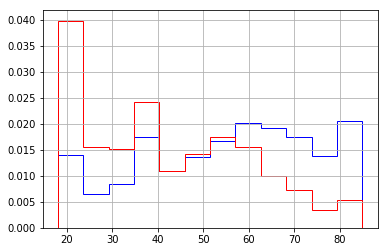

In [15]:
#EDA Age
display_distributions(selected_data,'SELF-REPORTED AGE (PUF 1 YR RECODE)', target_column)

This is interesting as it either suggests that younger people are more likely to experience psychological distress, or it suggests a generational issue that young people today are more likely to experience it since the survey did not measure this repeatedly over the course of the participants life. The distribution also seems to become less distressed around 60 years of age, which is also the typical age of retirment.

Ttest_indResult(statistic=-1.4048675661264787, pvalue=0.16020934472512455)


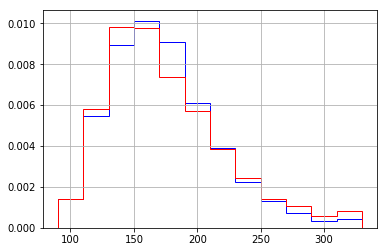

In [185]:
#EDA Weight
display_distributions(selected_data, 'WEIGHT: LBS (PUF RECODE)', target_column)

Ttest_indResult(statistic=-7.573128623554172, pvalue=5.503740178629196e-14)


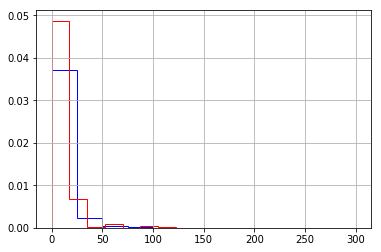

In [187]:
#EDA Fruit Drinks
display_distributions(selected_data, '# OF TIMES DRANK SWEET FRUIT DRINKS PAST MO', target_column)

Ttest_indResult(statistic=2.6932974258805724, pvalue=0.007131914809444713)


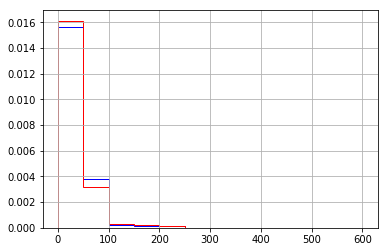

In [188]:
#EDA Fruit
display_distributions(selected_data, '# TIMES ATE FRUIT IN PAST MO', target_column)

Ttest_indResult(statistic=-5.6707578624150505, pvalue=1.6330737216389444e-08)


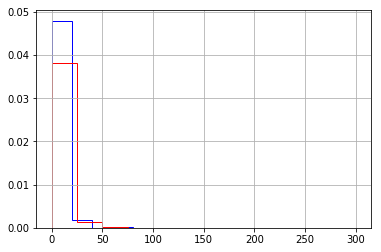

In [189]:
#EDA French Fries
display_distributions(selected_data, '# TIMES ATE FRNCH FRIES, HME FRIES, HSH BRWNS IN PAST MO', target_column)

Ttest_indResult(statistic=2.794875246990055, pvalue=0.0052392053779033365)


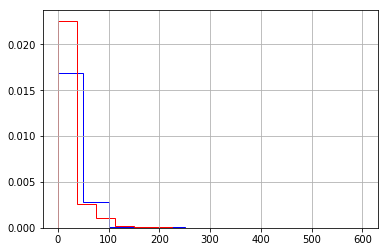

In [191]:
#EDA Vegetables
display_distributions(selected_data,'# OF TIMES ATE VEGETABLES IN PAST MO', target_column)

Ttest_indResult(statistic=19.658141495657674, pvalue=3.045477996682943e-79)


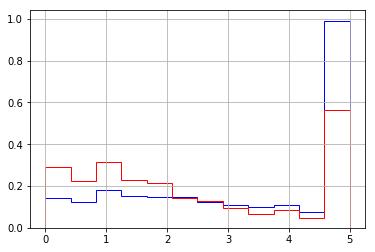

In [197]:
#EDA Poverty Level
display_distributions(selected_data, 'FAMILY POVERTY THRESHOLD LEVEL (PUF 1 YR RECODE)', target_column)

While this shows that a lower poverty level is correlated with high psychological distress, age also showed a similar pattern and younger people are more likely to have lower poverty level. Therefore it is possible that this pattern is because of age alone, poverty alone, or both.

[5.507543576973781, 14.813654870028186, 8.258893590346341, 4.216539717083786, 25.629077353215283]
Chi Squared p-value: 8.879677378608013e-08


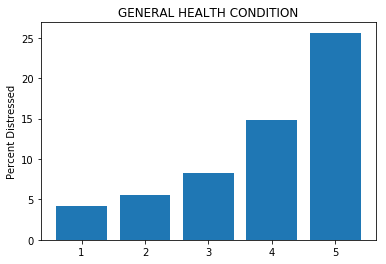

In [16]:
#EDA General Health Condition (1 excellent, 5 poor)
display_percentages(selected_data, "GENERAL HEALTH CONDITION", target_column)
p = chi_sq(selected_data, "SELF-REPORTED GENDER", target_column)
print("Chi Squared p-value: " + str(p))

[9.455006337135615, 7.375201288244766]
Chi Squared p-value: 8.879677378608013e-08


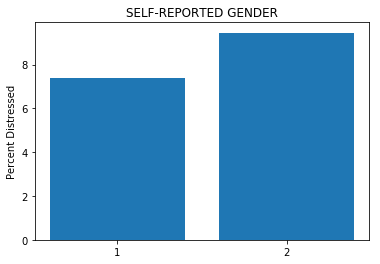

In [199]:
#EDA Gender (1 Male, 2 Female)
display_percentages(selected_data, "SELF-REPORTED GENDER", target_column)
p = chi_sq(selected_data, "SELF-REPORTED GENDER", target_column)
print("Chi Squared p-value: " + str(p))

[8.429421046243476, 8.925513698630137]
Chi Squared p-value: 0.29771533599316186


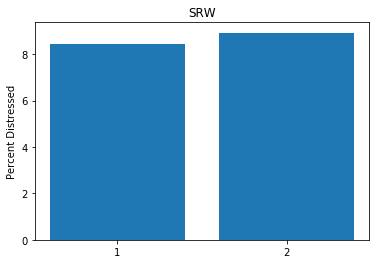

In [17]:
#EDA Race (1 White, 2 Non-White) 
#This column was removed from selected_data, must observe using original data
display_percentages(data, "SRW", "DSTRS12")
p = chi_sq(data, "SRW", "DSTRS12")
print("Chi Squared p-value: " + str(p))

Explore Collinearity with Target Column

In [18]:
#Highest Correlated Variables with Target Column
abs(selected_data.corr()[target_column]).sort_values(ascending=False).head(10)

LIKELY HAS HAD PSYCHOLOGICAL DISTRESS IN THE LAST YEAR                                  1.000000
SELF-REPORTED AGE (PUF 1 YR RECODE)                                                     0.194780
DELAY/NOT GET OTHER MEDICAL CARE IN PAST 12 MOS                                         0.194737
EVER SMOKED ELECTRONIC CIGARETTES                                                       0.183335
GENERAL HEALTH CONDITION                                                                0.168828
SELF-REPORTED HOUSEHOLD TENURE (HH)_1.0                                                 0.149696
SELF-REPORTED HOUSEHOLD TENURE (HH)_2.0                                                 0.149696
LENGTH OF TIME LIVED AT CURRENT ADDRESS (MONTHS) (PUF RECODE)                           0.145835
DELAY/NOT GET PRESCRIPTION IN PAST 12 MO                                                0.142322
EVER HAD PROBLEMS PAYING FOR SELF OR HOUSEHOLD FAMILY'S MEDICAL BILLS IN PAST 12 MOS    0.140673
Name: LIKELY HAS HAD PSYCHOLOG

Step 3: Models

3a: Preparing Data for Models

In [42]:
#Train Test Split
X = selected_data.drop(target_column, axis=1)
y = selected_data[[target_column]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
#Scale Data
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [44]:
#Define PR AUC metric
def precision_recall_auc(y_test, y_prob):
    precision, recall, threshold = metrics.precision_recall_curve(y_test, (1-y_prob), pos_label=1.)    
    return metrics.auc(recall, precision)
    
pr_auc = metrics.make_scorer(precision_recall_auc, greater_is_better=True, needs_proba=True)

3b: Random Forest

In [20]:
#RF GridSearchCV
n_estimator_space = [100, 200, 500]
max_features_space = [2, 5, 10, 20]
class_weight_space = ['balanced', 'balanced_subsample', None]
criterion_space = ['gini', 'entropy']
param_grid = {'n_estimators': n_estimator_space, 
              'max_features': max_features_space, 
              'class_weight': class_weight_space, 
              'criterion': criterion_space}
rf_tune = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_tune, param_grid, cv=3, scoring=pr_auc)
rf_cv.fit(scaled_X_train, y_train.values.ravel())
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_features': 10, 'n_estimators': 500}
0.35080889479050836


In [45]:
#Random Forest
rf = RandomForestClassifier(n_estimators = 500, 
                            max_features=10, 
                            random_state=42, 
                            criterion='entropy', 
                            class_weight=None)

rf_model = rf.fit(scaled_X_train, y_train.values.ravel())
y_pred = rf_model.predict(scaled_X_test)
y_prob = rf_model.predict_proba(scaled_X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[   5  356]
 [   5 3864]]
Classification Report
              precision    recall  f1-score   support

         1.0       0.50      0.01      0.03       361
         2.0       0.92      1.00      0.96      3869

   micro avg       0.91      0.91      0.91      4230
   macro avg       0.71      0.51      0.49      4230
weighted avg       0.88      0.91      0.88      4230



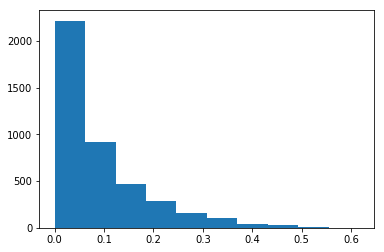

In [46]:
#RF Histogram of Probabilities
plt.hist(y_prob[:,0], bins=10)
plt.show()

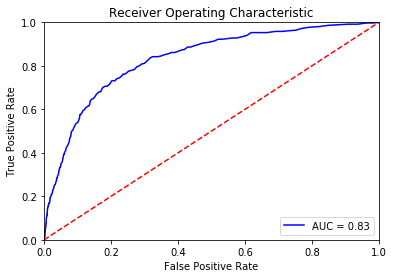

In [47]:
#RF ROC Curve
probs = y_prob[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

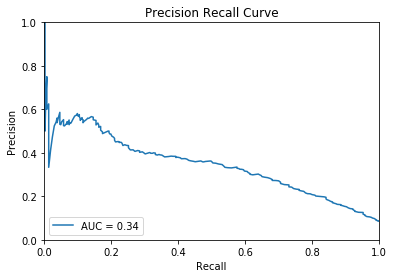

In [48]:
#Precision Recall Curve
probs = y_prob[:,0]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [49]:
#RF Feature Importances
feature_importances = pd.DataFrame()
feature_importances["feature"] = scaled_X_train.columns
feature_importances["importance"] = rf_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
40,SELF-REPORTED AGE (PUF 1 YR RECODE),0.051416
52,WEIGHT: LBS (PUF RECODE),0.042661
38,FAMILY POVERTY THRESHOLD LEVEL (PUF 1 YR RECODE),0.040351
20,# OF TIMES SAW MD IN PAST 12 MOS,0.038542
0,GENERAL HEALTH CONDITION,0.035866
51,LENGTH OF TIME LIVED AT CURRENT ADDRESS (MONTH...,0.033229
13,# OF TIMES ATE VEGETABLES IN PAST MO,0.032576
10,# TIMES ATE FRUIT IN PAST MO,0.032317
12,# TIMES ATE COOKED DRIED BEANS IN PAST MONTH,0.031101
6,# OF TIMES DRANK WATER YESTERDAY,0.030451


3c: Logistic Regression

In [26]:
#LR GridSearchCV
c_space = [0.01, 0.1, 1, 10, 100, 1000]
penalty_space = ['l1', 'l2']
class_weight_space = ['balanced', None]
param_grid = {'C': c_space, 
              'penalty': penalty_space, 
              'class_weight': class_weight_space}
lr_tune = LogisticRegression(solver='liblinear')
lr_cv = GridSearchCV(lr_tune, param_grid, cv=3, scoring=pr_auc)
lr_cv.fit(scaled_X_train, y_train.values.ravel())
print(lr_cv.best_params_)
print(lr_cv.best_score_)

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
0.3592721868227618


In [50]:
#Logistic Regression
lr = LogisticRegression(C=0.01, penalty='l1', class_weight='balanced', solver='liblinear')
lr_model = lr.fit(scaled_X_train, y_train.values.ravel())
y_pred = lr_model.predict(scaled_X_test)
y_prob = lr_model.predict_proba(scaled_X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[ 283   78]
 [ 948 2921]]
Classification Report
              precision    recall  f1-score   support

         1.0       0.23      0.78      0.36       361
         2.0       0.97      0.75      0.85      3869

   micro avg       0.76      0.76      0.76      4230
   macro avg       0.60      0.77      0.60      4230
weighted avg       0.91      0.76      0.81      4230



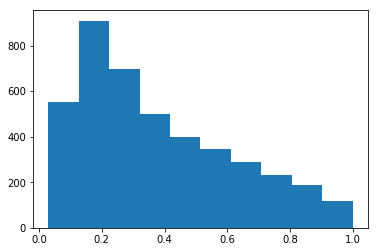

In [51]:
#LR Histogram of Probabilities
plt.hist(y_prob[:,0], bins=10)
plt.show()

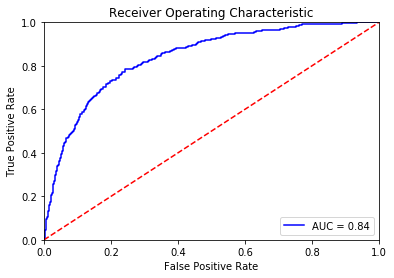

In [52]:
#LR ROC Curve
probs = y_prob[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

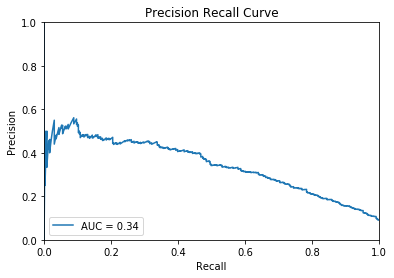

In [53]:
#LR Precision Recall Curve
probs = y_prob[:,0]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [54]:
#LR Feature importances
feature_importances = pd.DataFrame()
feature_importances["feature"] = scaled_X_train.columns
feature_importances["importance"] = list(abs(lr.coef_[0]))
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
40,SELF-REPORTED AGE (PUF 1 YR RECODE),0.661732
0,GENERAL HEALTH CONDITION,0.374618
18,DELAY/NOT GET OTHER MEDICAL CARE IN PAST 12 MOS,0.230001
49,SELF-REPORTED GENDER,0.160739
72,MARITAL STATUS- 4 CATEGORIES_1.0,0.146461
3,EVER TRIED MARIJUANA OR HASHISH,0.142452
28,HOW OFTEN FEEL SAFE IN NEIGHBORHOOD,0.125172
7,EVER SMOKED ELECTRONIC CIGARETTES,0.122219
21,EVER HAD PROBLEMS PAYING FOR SELF OR HOUSEHOLD...,0.109163
73,MARITAL STATUS- 4 CATEGORIES_2.0,0.105924


3d: K-Nearest Neighbors

In [32]:
#KNN GridSearchCV
neighbors_space = [10, 100, 500, 1000]
param_grid = {'n_neighbors': neighbors_space}
knn_tune = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_tune, param_grid, cv=3, scoring=pr_auc)
knn_cv.fit(scaled_X_train, y_train.values.ravel())
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 500}
0.3034583764029608


In [55]:
#KNN
knn = KNeighborsClassifier(n_neighbors=500)
knn_model = knn.fit(scaled_X_train, y_train.values.ravel())
y_pred = knn_model.predict(scaled_X_test)
y_prob = knn_model.predict_proba(scaled_X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[   0  361]
 [   0 3869]]
Classification Report
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       361
         2.0       0.91      1.00      0.96      3869

   micro avg       0.91      0.91      0.91      4230
   macro avg       0.46      0.50      0.48      4230
weighted avg       0.84      0.91      0.87      4230



/Users/jaredhammernik/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jaredhammernik/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jaredhammernik/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


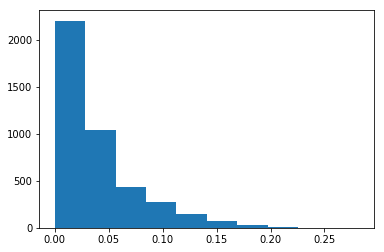

In [56]:
#KNN Histogram of Probabilities
plt.hist(y_prob[:,0], bins=10)
plt.show()

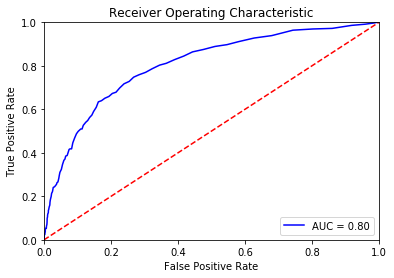

In [57]:
#KNN ROC Curve
probs = y_prob[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

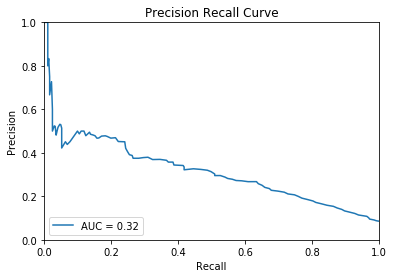

In [58]:
#KNN Precision Recall Curve
probs = y_prob[:,0]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
# No feature importances for KNN

3e: Gradient Boosting

In [37]:
#GB GridSearchCV
n_estimator_space = [100, 200, 500, 700]
max_features_space = [2, 5, 10, 20]
learning_rate_space = [0.01, 0.1, 0.5,  1]
loss_space = ['deviance', 'exponential']

param_grid = {'n_estimators': n_estimator_space, 
              'max_features': max_features_space, 
              'learning_rate': learning_rate_space, 
              'loss': loss_space}
gb_tune = GradientBoostingClassifier(random_state=42)
gb_cv = GridSearchCV(gb_tune, param_grid, cv=3, scoring=pr_auc)
gb_cv.fit(scaled_X_train, y_train.values.ravel())
print(gb_cv.best_params_)
print(gb_cv.best_score_)

{'learning_rate': 0.1, 'loss': 'deviance', 'max_features': 10, 'n_estimators': 100}
0.3608229837955651


In [59]:
#Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=0.1, 
                                loss='deviance', 
                                max_features=10, 
                                random_state=42)
gb_model = gb.fit(scaled_X_train, y_train.values.ravel())
y_pred = gb_model.predict(scaled_X_test)
y_prob = gb_model.predict_proba(scaled_X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[  41  320]
 [  42 3827]]
Classification Report
              precision    recall  f1-score   support

         1.0       0.49      0.11      0.18       361
         2.0       0.92      0.99      0.95      3869

   micro avg       0.91      0.91      0.91      4230
   macro avg       0.71      0.55      0.57      4230
weighted avg       0.89      0.91      0.89      4230



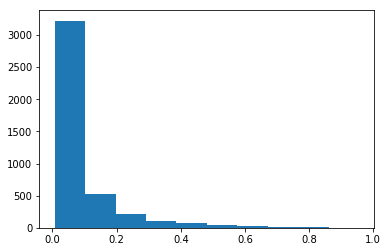

In [60]:
#GB Histogram of Probabilities
plt.hist(y_prob[:,0], bins=10)
plt.show()

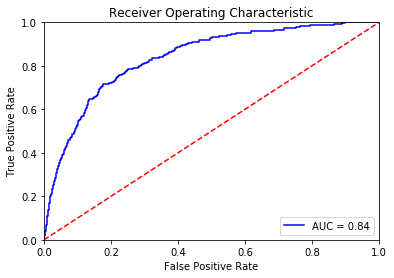

In [61]:
#GB ROC Curve
probs = y_prob[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

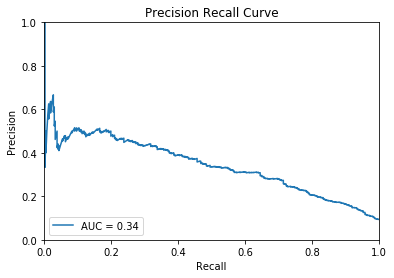

In [62]:
#GB Precision Recall Curve
probs = y_prob[:,0]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [63]:
#GB Feature Importances
feature_importances = pd.DataFrame()
feature_importances["feature"] = scaled_X_train.columns
feature_importances["importance"] = gb_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
0,GENERAL HEALTH CONDITION,0.123560
40,SELF-REPORTED AGE (PUF 1 YR RECODE),0.115419
18,DELAY/NOT GET OTHER MEDICAL CARE IN PAST 12 MOS,0.097652
7,EVER SMOKED ELECTRONIC CIGARETTES,0.094165
21,EVER HAD PROBLEMS PAYING FOR SELF OR HOUSEHOLD...,0.042171
20,# OF TIMES SAW MD IN PAST 12 MOS,0.036883
79,SELF-REPORTED HOUSEHOLD TENURE (HH)_2.0,0.033323
38,FAMILY POVERTY THRESHOLD LEVEL (PUF 1 YR RECODE),0.033204
17,DELAY/NOT GET PRESCRIPTION IN PAST 12 MO,0.029938
74,MARITAL STATUS- 4 CATEGORIES_4.0,0.029573


3f: Ensemble Voting Classifier

In [68]:
#VotingClassisfier
vc = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('lr', lr), ('knn', knn)], voting='soft')
vc.fit(scaled_X_train, y_train.values.ravel())
y_pred = vc.predict(scaled_X_test)
y_prob = vc.predict_proba(scaled_X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[  31  330]
 [  31 3838]]
Classification Report
              precision    recall  f1-score   support

         1.0       0.50      0.09      0.15       361
         2.0       0.92      0.99      0.96      3869

   micro avg       0.91      0.91      0.91      4230
   macro avg       0.71      0.54      0.55      4230
weighted avg       0.88      0.91      0.89      4230



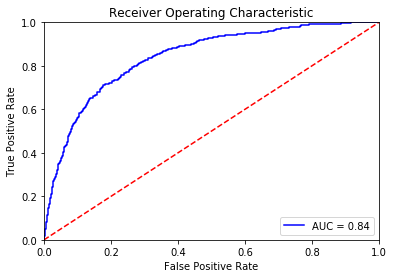

In [69]:
#VC ROC Curve
probs = y_prob[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

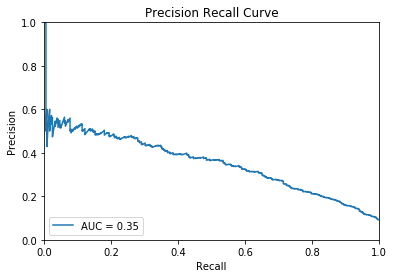

In [70]:
#VC Precision Recall Curve
probs = y_prob[:,0]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Step 4: Conclusion and Next Steps

In [ ]:
#